## Library

In [1]:
import sys
sys.path.append("../../")

In [2]:
SAVE_PATH = "../storage/demo/cnp_rnn.ckpt"

In [3]:
import numpy as np               
import pandas as pd
import random as rn
import tensorflow as tf
import matplotlib.pyplot as plt
import collections
from tqdm import tqdm     # Dynamic progress bars
import glob               # Lets us check if checkpoint files exist
from tensorflow.keras.optimizers import Adam
from tensorflow.python.keras.layers import Input, Dense, LSTM
from tensorflow.python.keras.models import Sequential

In [4]:
tf.logging.set_verbosity(tf.logging.ERROR)  # Suppress depreciation warnings
tf.__version__

'1.15.0'

In [5]:
from neuralprocesses.np.aux import DataProvider
from neuralprocesses.utils.tf_utils import tf_sort_by_col
from neuralprocesses.utils.gp import GaussianProcess
from neuralprocesses.utils.gp import squared_exponential_kernel

from neuralprocesses.np.cnp import ConditionalNeuralProcess

from neuralprocesses.utils.plotting import list_plot
from neuralprocesses.utils.plotting import Color

## Data

In [6]:
data = pd.read_csv('daily-min-temperatures.csv', sep=",")
data['Date'] = pd.to_datetime(data['Date'])
data = data.set_index(['Date'])
data['X'] = np.arange(len(data))
data

,Temp,X
Date,,
1981-01-01,20.7,0
1981-01-02,17.9,1
1981-01-03,18.8,2
1981-01-04,14.6,3
1981-01-05,15.8,4
...,...,...
1990-12-27,14.0,3645
1990-12-28,13.6,3646
1990-12-29,13.5,3647


## Data Preprocessing

In [7]:
data_train = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[:365]
data_test_1 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365:365*2]
data_test_2 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*2:365*3]
data_test_3 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*3:365*4]
data_test_4 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*4:365*5]
data_test_5 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*5:365*6]
data_test_6 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*6:365*7]
data_test_7 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*7:365*8]
data_test_8 = pd.DataFrame(data[['Temp','X']].values, columns=['T','X']).loc[365*8:365*9]

mean_value = data_train['T'].mean()
data_train['T'] = (data_train['T'] - mean_value)/mean_value
data_test_1['T'] = (data_test_1['T'] - mean_value)/mean_value
data_test_2['T'] = (data_test_2['T'] - mean_value)/mean_value
data_test_3['T'] = (data_test_3['T'] - mean_value)/mean_value
data_test_4['T'] = (data_test_4['T'] - mean_value)/mean_value
data_test_5['T'] = (data_test_5['T'] - mean_value)/mean_value
data_test_6['T'] = (data_test_6['T'] - mean_value)/mean_value
data_test_7['T'] = (data_test_7['T'] - mean_value)/mean_value
data_test_8['T'] = (data_test_8['T'] - mean_value)/mean_value


for s in range(1,2):
    data_train['Y'.format(s)] = data_train['T'].shift(s)
    data_test_1['Y'.format(s)] = data_test_1['T'].shift(s)
    data_test_2['Y'.format(s)] = data_test_2['T'].shift(s)
    data_test_3['Y'.format(s)] = data_test_3['T'].shift(s)
    data_test_4['Y'.format(s)] = data_test_4['T'].shift(s)
    data_test_5['Y'.format(s)] = data_test_5['T'].shift(s)
    data_test_6['Y'.format(s)] = data_test_6['T'].shift(s)
    data_test_7['Y'.format(s)] = data_test_7['T'].shift(s)
    data_test_8['Y'.format(s)] = data_test_8['T'].shift(s)

data_train = data_train.dropna()
data_test_1 = data_test_1.dropna()
data_test_2 = data_test_2.dropna()
data_test_3 = data_test_3.dropna()
data_test_4 = data_test_4.dropna()
data_test_5 = data_test_5.dropna()
data_test_6 = data_test_6.dropna()
data_test_7 = data_test_7.dropna()
data_test_8 = data_test_8.dropna()
X_train = data_train.drop(['X','T'], axis=1)
y_train = data_train.drop(['X','Y'], axis=1)
X_test_1 = data_test_1.drop(['X','T'], axis=1)
y_test_1 = data_test_1.drop(['X','Y'], axis=1)
X_test_2 = data_test_2.drop(['X','T'], axis=1)
y_test_2 = data_test_2.drop(['X','Y'], axis=1)
X_test_3 = data_test_3.drop(['X','T'], axis=1)
y_test_3 = data_test_3.drop(['X','Y'], axis=1)
X_test_4 = data_test_4.drop(['X','T'], axis=1)
y_test_4 = data_test_4.drop(['X','Y'], axis=1)
X_test_5 = data_test_5.drop(['X','T'], axis=1)
y_test_5 = data_test_5.drop(['X','Y'], axis=1)
X_test_6 = data_test_6.drop(['X','T'], axis=1)
y_test_6 = data_test_6.drop(['X','Y'], axis=1)
X_test_7 = data_test_7.drop(['X','T'], axis=1)
y_test_7 = data_test_7.drop(['X','Y'], axis=1)
X_test_8 = data_test_8.drop(['X','T'], axis=1)
y_test_8 = data_test_8.drop(['X','Y'], axis=1)


print('Train size: (%d x %d)'%(X_train.shape[0], X_train.shape[1]))
print('Test 1 size: (%d x %d)'%(y_test_1.shape[0], y_test_1.shape[1]))
print('Test 2 size: (%d x %d)'%(y_test_2.shape[0], y_test_2.shape[1]))
print('Test 3 size: (%d x %d)'%(y_test_3.shape[0], y_test_3.shape[1]))
print('Test 4 size: (%d x %d)'%(y_test_4.shape[0], y_test_4.shape[1]))
print('Test 5 size: (%d x %d)'%(y_test_5.shape[0], y_test_5.shape[1]))
print('Test 6 size: (%d x %d)'%(y_test_6.shape[0], y_test_6.shape[1]))
print('Test 7 size: (%d x %d)'%(y_test_7.shape[0], y_test_7.shape[1]))
print('Test 8 size: (%d x %d)'%(y_test_8.shape[0], y_test_8.shape[1]))

Train size: (365 x 1)
Test 1 size: (365 x 1)
Test 2 size: (365 x 1)
Test 3 size: (365 x 1)
Test 4 size: (365 x 1)
Test 5 size: (365 x 1)
Test 6 size: (365 x 1)
Test 7 size: (365 x 1)
Test 8 size: (365 x 1)


### LSTM Dataset

In [8]:
# convert an array of values into a dataset matrix
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back)]
        dataX.append(a)
        dataY.append(dataset[i + look_back])
    return pd.DataFrame(np.array(dataX)), pd.DataFrame(np.array(dataY))

In [9]:
dataX, dataY = create_dataset(data['Temp'],3)
X_train_lstm = dataX[:363]
y_train_lstm = dataY[:363]
X_test_1_lstm = dataX[363:363+365]
y_test_1_lstm = dataY[363:363+365]
X_test_2_lstm = dataX[363+365:363+365*2]
y_test_2_lstm = dataY[363+365:363+365*2]
X_test_3_lstm = dataX[363+365*2:363+365*3]
y_test_3_lstm = dataY[363+365*2:363+365*3]
X_test_4_lstm = dataX[363+365*3:363+365*4]
y_test_4_lstm = dataY[363+365*3:363+365*4]
X_test_5_lstm = dataX[363+365*4:363+365*5]
y_test_5_lstm = dataY[363+365*4:363+365*5]
X_test_6_lstm = dataX[363+365*5:363+365*6]
y_test_6_lstm = dataY[363+365*5:363+365*6]
X_test_7_lstm = dataX[363+365*6:363+365*7]
y_test_7_lstm = dataY[363+365*6:363+365*7]
X_test_8_lstm = dataX[363+365*7:363+365*8]
y_test_8_lstm = dataY[363+365*7:363+365*8]

mean_X_train_lstm = X_train_lstm.mean()
mean_y_train_lstm = y_train_lstm.mean()
X_train_lstm = (X_train_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_train_lstm = (y_train_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_1_lstm = (X_test_1_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_1_lstm = (y_test_1_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_2_lstm = (X_test_2_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_2_lstm = (y_test_2_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_3_lstm = (X_test_3_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_3_lstm = (y_test_3_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_4_lstm = (X_test_4_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_4_lstm = (y_test_4_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_5_lstm = (X_test_5_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_5_lstm = (y_test_5_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_6_lstm = (X_test_6_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_6_lstm = (y_test_6_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_7_lstm = (X_test_7_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_7_lstm = (y_test_7_lstm - mean_y_train_lstm)/mean_y_train_lstm
X_test_8_lstm = (X_test_8_lstm - mean_X_train_lstm)/mean_X_train_lstm
y_test_8_lstm = (y_test_8_lstm - mean_y_train_lstm)/mean_y_train_lstm

# reshape input to be [samples, time steps, features]
X_train_lstm = np.reshape(X_train_lstm.values, (X_train_lstm.shape[0], X_train_lstm.shape[1], 1))
X_test_1_lstm = np.reshape(X_test_1_lstm.values, (X_test_1_lstm.shape[0], X_test_1_lstm.shape[1], 1))
X_test_2_lstm = np.reshape(X_test_2_lstm.values, (X_test_2_lstm.shape[0], X_test_2_lstm.shape[1], 1))
X_test_3_lstm = np.reshape(X_test_3_lstm.values, (X_test_3_lstm.shape[0], X_test_3_lstm.shape[1], 1))
X_test_4_lstm = np.reshape(X_test_4_lstm.values, (X_test_4_lstm.shape[0], X_test_4_lstm.shape[1], 1))
X_test_5_lstm = np.reshape(X_test_5_lstm.values, (X_test_5_lstm.shape[0], X_test_5_lstm.shape[1], 1))
X_test_6_lstm = np.reshape(X_test_6_lstm.values, (X_test_6_lstm.shape[0], X_test_6_lstm.shape[1], 1))
X_test_7_lstm = np.reshape(X_test_7_lstm.values, (X_test_7_lstm.shape[0], X_test_7_lstm.shape[1], 1))
X_test_8_lstm = np.reshape(X_test_8_lstm.values, (X_test_8_lstm.shape[0], X_test_8_lstm.shape[1], 1))

## RNN Model

In [10]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

nn = Sequential()
nn.add(Dense(20, input_shape=(X_train.shape[1],), activation='relu', kernel_initializer='lecun_uniform'))
nn.add(Dense(1))

adam = Adam(lr=0.1, beta_1=0.92, beta_2=0.999, decay=0.0, amsgrad=False)
nn.compile(optimizer=adam, loss='mean_absolute_error')
nn.summary()
history_nn = nn.fit(x=X_train, y=y_train, batch_size=1, epochs=17, verbose=1, callbacks=None)
y_pred_nn_1 = nn.predict(X_test_1)
y_pred_nn_2 = nn.predict(X_test_2)
y_pred_nn_3 = nn.predict(X_test_3)
y_pred_nn_4 = nn.predict(X_test_4)
y_pred_nn_5 = nn.predict(X_test_5)
y_pred_nn_6 = nn.predict(X_test_6)
y_pred_nn_7 = nn.predict(X_test_7)
y_pred_nn_8 = nn.predict(X_test_8)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 20)                40        
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 21        
Total params: 61
Trainable params: 61
Non-trainable params: 0
_________________________________________________________________
Train on 365 samples
Epoch 1/17
365/365 [==============================] - 1s 1ms/sample - loss: 0.2556
Epoch 2/17
365/365 [==============================] - 0s 617us/sample - loss: 0.2584
Epoch 3/17
365/365 [==============================] - 0s 624us/sample - loss: 0.2525
Epoch 4/17
365/365 [==============================] - 0s 623us/sample - loss: 0.2294
Epoch 5/17
365/365 [==============================] - 0s 623us/sample - loss: 0.2475
Epoch 6/17
365/365 [==============================] - 0s 621us/sample - loss: 

## LSTM Model

In [11]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

model = Sequential()
model.add(LSTM(15, input_shape=(3, 1), recurrent_activation='relu'))
model.add(Dense(1))
model.compile(loss='mean_absolute_error', optimizer='adam')
model.summary()
model.fit(X_train_lstm, y_train_lstm, epochs=15, batch_size=5, verbose=1)
y_pred_lstm_1 = model.predict(X_test_1_lstm)
y_pred_lstm_2 = model.predict(X_test_2_lstm)
y_pred_lstm_3 = model.predict(X_test_3_lstm)
y_pred_lstm_4 = model.predict(X_test_4_lstm)
y_pred_lstm_5 = model.predict(X_test_5_lstm)
y_pred_lstm_6 = model.predict(X_test_6_lstm)
y_pred_lstm_7 = model.predict(X_test_7_lstm)
y_pred_lstm_8 = model.predict(X_test_8_lstm)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 15)                1020      
_________________________________________________________________
dense (Dense)                (None, 1)                 16        
Total params: 1,036
Trainable params: 1,036
Non-trainable params: 0
_________________________________________________________________
Train on 363 samples
Epoch 1/15
363/363 [==============================] - 1s 2ms/sample - loss: 0.2999
Epoch 2/15
363/363 [==============================] - 0s 491us/sample - loss: 0.2883
Epoch 3/15
363/363 [==============================] - 0s 463us/sample - loss: 0.2295
Epoch 4/15
363/363 [==============================] - 0s 454us/sample - loss: 0.1815
Epoch 5/15
363/363 [==============================] - 0s 457us/sample - loss: 0.1792
Epoch 6/15
363/363 [==============================] - 0s 468us/sample - 

## CNP DATA

In [12]:
tf.reset_default_graph()
tf.set_random_seed(2019)
tf.disable_eager_execution()

In [13]:
def target_split(data, interval):
    target_index_list = list([True if (i+1)%interval==0 else False for i in list(np.arange(0, data.shape[0], 1))])
    context_index_list = list([False if (i+1)%interval==0 else True for i in list(np.arange(0, data.shape[0], 1))])
    target = data.loc[target_index_list]
    context = data.loc[context_index_list]
    return context, target

In [14]:
BATCH_SIZE = 1
plotting_mode = tf.placeholder(dtype=tf.bool, name="plotting_mode")
interval_num = 2
context_cnp, target_cnp = target_split(data_train,interval_num)
context_test_1, target_test_1 = target_split(data_test_1,interval_num)
context_test_2, target_test_2 = target_split(data_test_2,interval_num)
context_test_3, target_test_3 = target_split(data_test_3,interval_num)
context_test_4, target_test_4 = target_split(data_test_4,interval_num)
context_test_5, target_test_5 = target_split(data_test_5,interval_num)
context_test_6, target_test_6 = target_split(data_test_6,interval_num)
context_test_7, target_test_7 = target_split(data_test_7,interval_num)
context_test_8, target_test_8 = target_split(data_test_8,interval_num)

# Choose the number of context points
num_context_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(context_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

# Choose the number of target points
num_target_points = tf.random_uniform(
    shape=(),
    minval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE, tf.int32, name=None),
    maxval=tf.dtypes.saturate_cast(target_cnp.shape[0]/BATCH_SIZE+1, tf.int32, name=None),
    dtype=tf.int32
)

In [15]:
# Train
x_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context = tf.dtypes.saturate_cast(tf.reshape(context_cnp['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target = tf.dtypes.saturate_cast(tf.reshape(target_cnp['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 1
x_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test = tf.dtypes.saturate_cast(tf.reshape(context_test_1['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test = tf.dtypes.saturate_cast(tf.reshape(target_test_1['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 2
x_context_test_2 = tf.dtypes.saturate_cast(tf.reshape(context_test_2['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_2 = tf.dtypes.saturate_cast(tf.reshape(context_test_2['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_2 = tf.dtypes.saturate_cast(tf.reshape(target_test_2['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_2 = tf.dtypes.saturate_cast(tf.reshape(target_test_2['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 3
x_context_test_3 = tf.dtypes.saturate_cast(tf.reshape(context_test_3['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_3 = tf.dtypes.saturate_cast(tf.reshape(context_test_3['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_3 = tf.dtypes.saturate_cast(tf.reshape(target_test_3['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_3 = tf.dtypes.saturate_cast(tf.reshape(target_test_3['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 4
x_context_test_4 = tf.dtypes.saturate_cast(tf.reshape(context_test_4['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_4 = tf.dtypes.saturate_cast(tf.reshape(context_test_4['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_4 = tf.dtypes.saturate_cast(tf.reshape(target_test_4['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_4 = tf.dtypes.saturate_cast(tf.reshape(target_test_4['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 5
x_context_test_5 = tf.dtypes.saturate_cast(tf.reshape(context_test_5['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_5 = tf.dtypes.saturate_cast(tf.reshape(context_test_5['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_5 = tf.dtypes.saturate_cast(tf.reshape(target_test_5['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_5 = tf.dtypes.saturate_cast(tf.reshape(target_test_5['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 6
x_context_test_6 = tf.dtypes.saturate_cast(tf.reshape(context_test_6['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_6 = tf.dtypes.saturate_cast(tf.reshape(context_test_6['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_6 = tf.dtypes.saturate_cast(tf.reshape(target_test_6['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_6 = tf.dtypes.saturate_cast(tf.reshape(target_test_6['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 7
x_context_test_7 = tf.dtypes.saturate_cast(tf.reshape(context_test_7['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_7 = tf.dtypes.saturate_cast(tf.reshape(context_test_7['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_7 = tf.dtypes.saturate_cast(tf.reshape(target_test_7['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_7 = tf.dtypes.saturate_cast(tf.reshape(target_test_7['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

# Test 8
x_context_test_8 = tf.dtypes.saturate_cast(tf.reshape(context_test_8['X'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
y_context_test_8 = tf.dtypes.saturate_cast(tf.reshape(context_test_8['Y'], [BATCH_SIZE,num_context_points]), tf.float32, name=None)
x_target_test_8 = tf.dtypes.saturate_cast(tf.reshape(target_test_8['X'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)
y_target_test_8 = tf.dtypes.saturate_cast(tf.reshape(target_test_8['Y'], [BATCH_SIZE,num_target_points]), tf.float32, name=None)

In [16]:
import collections
RegressionInput = collections.namedtuple(
    "RegressionInput",
    ("queries", "targets", "num_context", "num_target"))
data = RegressionInput(queries=((x_context, y_context), x_target), targets=y_target, num_context=num_context_points, num_target=num_target_points)

## GP Model

In [17]:
#kernel = lambda x: squared_exponential_kernel(x, 2.0)
gp_model = GaussianProcess(squared_exponential_kernel, name="gp-model")

In [18]:
_, gp_mean, gp_variance, _ = gp_model(((x_context, y_context), x_target))

In [19]:
with tf.variable_scope("gp_plot"):
    gp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    gp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0]], axis=1), 0)
    gp_plot_max = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] + tf.sqrt(gp_variance[0])], axis=1), 0)
    gp_plot_min = tf_sort_by_col(tf.stack([x_target[0], gp_mean[0] - tf.sqrt(gp_variance[0])], axis=1), 0)

## CNP Model

In [20]:
cnp = ConditionalNeuralProcess(name="cnp-model", aggregator="RNN")

In [21]:
cnp_mean, cnp_variance, cnp_loss = cnp(data)

In [22]:
with tf.variable_scope("cnp_trainer"):
    optimizer = tf.train.AdamOptimizer()
    training_step = optimizer.minimize(cnp_loss)

In [23]:
with tf.variable_scope("cnp_plot"):
    cnp_plot_context = tf_sort_by_col(tf.stack([x_context[0], y_context[0]], axis=1), 0)
    cnp_plot_mean = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0]], axis=1), 0)
    cnp_plot_max = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] + tf.sqrt(cnp_variance[0])], axis=1), 0)
    cnp_plot_min = tf_sort_by_col(tf.stack([x_target[0], cnp_mean[0] - tf.sqrt(cnp_variance[0])], axis=1), 0)

### Training

In [24]:
init = tf.global_variables_initializer()
saver = tf.train.Saver()

In [25]:
NUM_EPISODES = 300
SAVE_STEP = 100

with tf.Session() as session:
    
    # Initialize variables
    init = tf.global_variables_initializer()
    saver = tf.train.Saver( 
        max_to_keep=4, 
        keep_checkpoint_every_n_hours=1
    )
    session.run(init)

    # Do training
    for episode in tqdm(range(NUM_EPISODES)):
        session.run(training_step, feed_dict={plotting_mode: False})

        if episode % SAVE_STEP == 0 or episode == NUM_EPISODES - 1:
            saver.save(session, SAVE_PATH, global_step=episode)

    # Save resulting graph
    print(f"Model saved in: {saver.save(session, SAVE_PATH)}")

100%|██████████| 300/300 [00:21<00:00, 13.88it/s]

Model saved in: ../storage/demo/cnp_rnn.ckpt


## Prediction

In [26]:
def gp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [gp_plot_context, gp_plot_mean, gp_plot_max, gp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        # Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )
        return xy

In [27]:
def cnp_predict(xc, yc, xt, ground_truth_data):
    with tf.Session() as session:
        saver.restore(session, SAVE_PATH)
        
        #xt = list(yt.index)
        batch_size = BATCH_SIZE  # ToDo: How can we change the batch size after loading?

        # Compute a test case for plotting
        ctxt, xy, xymax, xymin = session.run(
            [cnp_plot_context, cnp_plot_mean, cnp_plot_max, cnp_plot_min],
            feed_dict={
                plotting_mode: True,
                data.queries[0][0]: [xc for b in range(batch_size)],
                data.queries[0][1]: [yc for b in range(batch_size)],
                data.queries[1]: [xt for b in range(batch_size)],
                data.num_context: len(xc),
                data.num_target: len(xt)
            }
        )
        '''# Plot the result
        list_plot([xy, xymin, xymax, ctxt, ground_truth_data],
              joined=[True,True,True,False], 
              mesh=[False,False,False,True],
              plot_style=[
                  # Mean in gray
                  Color((0.3,0.3,0.3)),  
                  # Confidence interval bounds in blue
                  Color.color_data(n=1),
                  Color.color_data(n=1),
                  # Context points as Red crosses
                  {"Color": Color.color_data(n=0), "Marker": "+", "PointSize": 300},
                  # Ground truth in black
                  Color((0,0,0))
              ],
              axes_label=("x", "y"),
              filling=[[1,2]]
        )'''
        return xy, xymax, xymin

In [28]:
with tf.Session() as session:
    xc, yc, xt, yt = session.run([
        x_context_test[0], y_context_test[0], x_target_test[0], y_target_test[0]], feed_dict={plotting_mode: True})
    xc_2, yc_2, xt_2, yt_2 = session.run([
        x_context_test_2[0], y_context_test_2[0], x_target_test_2[0], y_target_test_2[0]], feed_dict={plotting_mode: True})
    xc_3, yc_3, xt_3, yt_3 = session.run([
        x_context_test_3[0], y_context_test_3[0], x_target_test_3[0], y_target_test_3[0]], feed_dict={plotting_mode: True})
    xc_4, yc_4, xt_4, yt_4 = session.run([
        x_context_test_4[0], y_context_test_4[0], x_target_test_4[0], y_target_test_4[0]], feed_dict={plotting_mode: True})
    xc_5, yc_5, xt_5, yt_5 = session.run([
        x_context_test_5[0], y_context_test_5[0], x_target_test_5[0], y_target_test_5[0]], feed_dict={plotting_mode: True})
    xc_6, yc_6, xt_6, yt_6 = session.run([
        x_context_test_6[0], y_context_test_6[0], x_target_test_6[0], y_target_test_6[0]], feed_dict={plotting_mode: True})
    xc_7, yc_7, xt_7, yt_7 = session.run([
        x_context_test_7[0], y_context_test_7[0], x_target_test_7[0], y_target_test_7[0]], feed_dict={plotting_mode: True})
    xc_8, yc_8, xt_8, yt_8 = session.run([
        x_context_test_8[0], y_context_test_8[0], x_target_test_8[0], y_target_test_8[0]], feed_dict={plotting_mode: True})

# Result

### - RNN

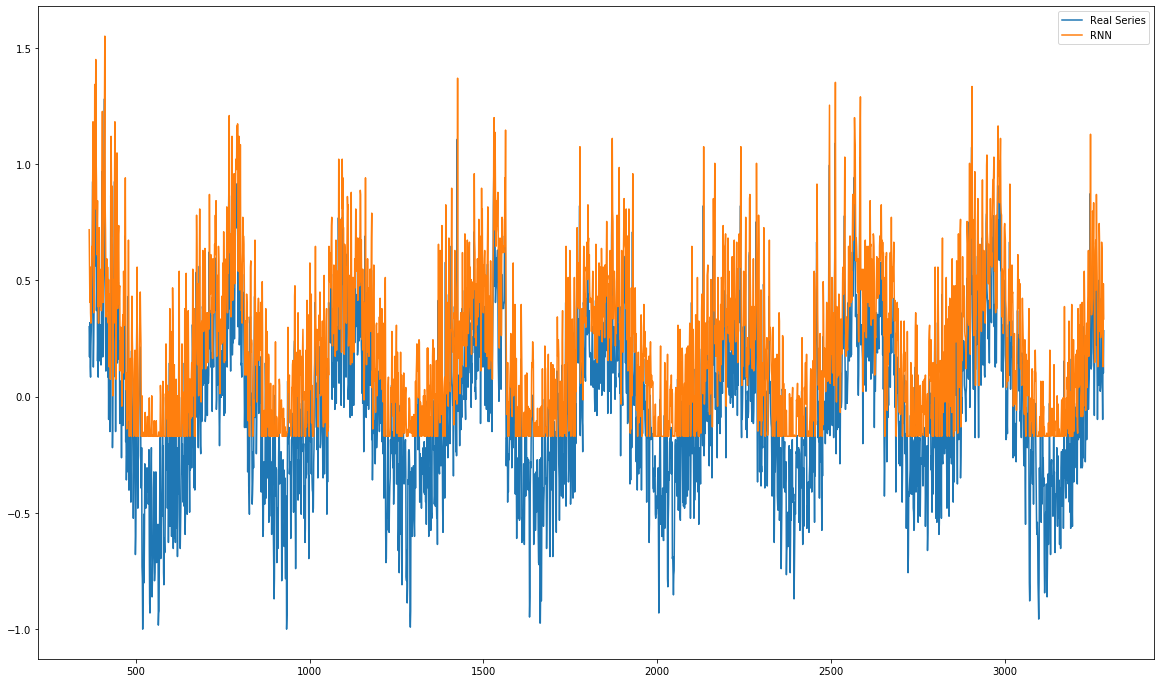

MSE RNN P1:    0.15
MSE RNN P2:    0.12
MSE RNN P3:    0.13
MSE RNN P4:    0.12
MSE RNN P5:    0.12
MSE RNN P6:    0.12
MSE RNN P7:    0.12
MSE RNN P8:    0.11


In [29]:
y_pred_nn_1=pd.DataFrame(y_pred_nn_1, index=y_test_1.index)
y_pred_nn_2=pd.DataFrame(y_pred_nn_2, index=y_test_2.index)
y_pred_nn_3=pd.DataFrame(y_pred_nn_3, index=y_test_3.index)
y_pred_nn_4=pd.DataFrame(y_pred_nn_4, index=y_test_4.index)
y_pred_nn_5=pd.DataFrame(y_pred_nn_5, index=y_test_5.index)
y_pred_nn_6=pd.DataFrame(y_pred_nn_6, index=y_test_6.index)
y_pred_nn_7=pd.DataFrame(y_pred_nn_7, index=y_test_7.index)
y_pred_nn_8=pd.DataFrame(y_pred_nn_8, index=y_test_8.index)
plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1,y_test_2,y_test_3,y_test_4,y_test_5,y_test_6,y_test_7,y_test_8]), label='Real Series')
plt.plot(pd.concat([y_pred_nn_1,y_pred_nn_2,y_pred_nn_3,y_pred_nn_4,y_pred_nn_5,y_pred_nn_6,y_pred_nn_7,y_pred_nn_8]), label='RNN')
plt.legend()
plt.show()
print("MSE RNN P1: {0:7.2f}".format((np.square(y_test_1 - y_pred_nn_1.values)).values.mean()))
print("MSE RNN P2: {0:7.2f}".format((np.square(y_test_2 - y_pred_nn_2.values)).values.mean()))
print("MSE RNN P3: {0:7.2f}".format((np.square(y_test_3 - y_pred_nn_3.values)).values.mean()))
print("MSE RNN P4: {0:7.2f}".format((np.square(y_test_4 - y_pred_nn_4.values)).values.mean()))
print("MSE RNN P5: {0:7.2f}".format((np.square(y_test_5 - y_pred_nn_5.values)).values.mean()))
print("MSE RNN P6: {0:7.2f}".format((np.square(y_test_6 - y_pred_nn_6.values)).values.mean()))
print("MSE RNN P7: {0:7.2f}".format((np.square(y_test_7 - y_pred_nn_7.values)).values.mean()))
print("MSE RNN P8: {0:7.2f}".format((np.square(y_test_8 - y_pred_nn_8.values)).values.mean()))

### - LSTM

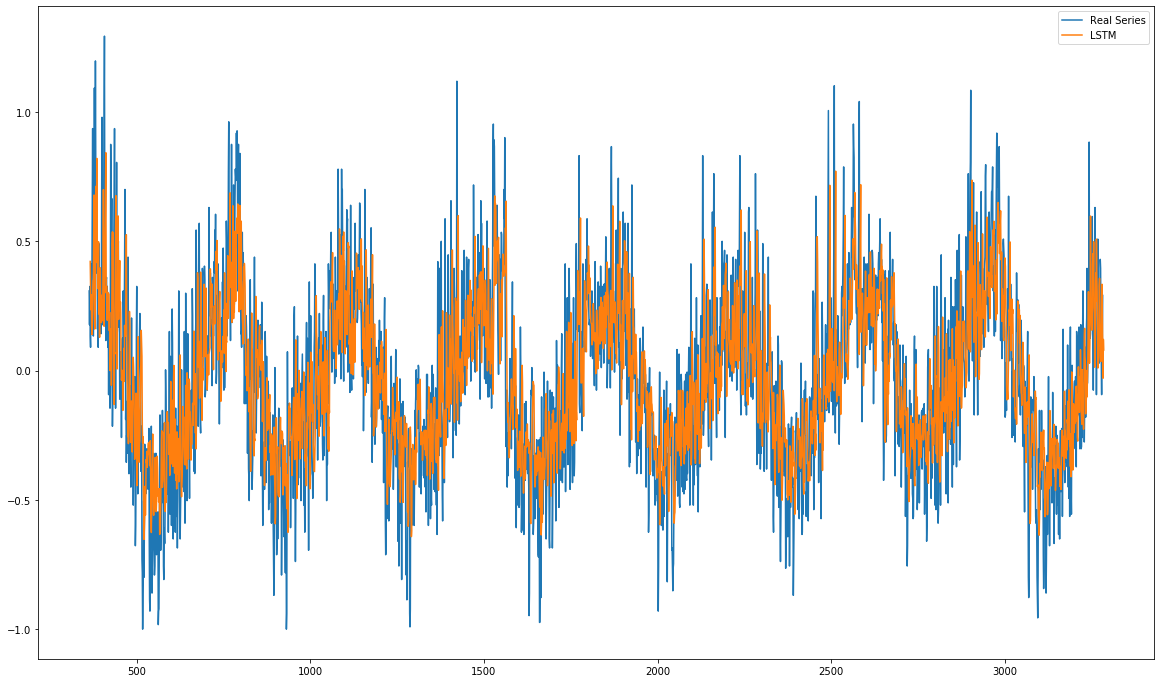

MSE LSTM P1:    0.06
MSE LSTM P2:    0.05
MSE LSTM P3:    0.05
MSE LSTM P4:    0.05
MSE LSTM P5:    0.05
MSE LSTM P6:    0.05
MSE LSTM P7:    0.05
MSE LSTM P8:    0.04


In [30]:
y_pred_lstm_1=pd.DataFrame(y_pred_lstm_1, index=y_test_1.index)
y_pred_lstm_2=pd.DataFrame(y_pred_lstm_2, index=y_test_2.index)
y_pred_lstm_3=pd.DataFrame(y_pred_lstm_3, index=y_test_3.index)
y_pred_lstm_4=pd.DataFrame(y_pred_lstm_4, index=y_test_4.index)
y_pred_lstm_5=pd.DataFrame(y_pred_lstm_5, index=y_test_5.index)
y_pred_lstm_6=pd.DataFrame(y_pred_lstm_6, index=y_test_6.index)
y_pred_lstm_7=pd.DataFrame(y_pred_lstm_7, index=y_test_7.index)
y_pred_lstm_8=pd.DataFrame(y_pred_lstm_8, index=y_test_8.index)
plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1_lstm,y_test_2_lstm,y_test_3_lstm,y_test_4_lstm,y_test_5_lstm,y_test_6_lstm,y_test_7_lstm,y_test_8_lstm]), label='Real Series')
plt.plot(pd.concat([y_pred_lstm_1,y_pred_lstm_2,y_pred_lstm_3,y_pred_lstm_4,y_pred_lstm_5,y_pred_lstm_6,y_pred_lstm_7,y_pred_lstm_8]), label='LSTM')
plt.legend()
plt.show()
print("MSE LSTM P1: {0:7.2f}".format((np.square(y_test_1_lstm - y_pred_lstm_1.values)).values.mean()))
print("MSE LSTM P2: {0:7.2f}".format((np.square(y_test_2_lstm - y_pred_lstm_2.values)).values.mean()))
print("MSE LSTM P3: {0:7.2f}".format((np.square(y_test_3_lstm - y_pred_lstm_3.values)).values.mean()))
print("MSE LSTM P4: {0:7.2f}".format((np.square(y_test_4_lstm - y_pred_lstm_4.values)).values.mean()))
print("MSE LSTM P5: {0:7.2f}".format((np.square(y_test_5_lstm - y_pred_lstm_5.values)).values.mean()))
print("MSE LSTM P6: {0:7.2f}".format((np.square(y_test_6_lstm - y_pred_lstm_6.values)).values.mean()))
print("MSE LSTM P7: {0:7.2f}".format((np.square(y_test_7_lstm - y_pred_lstm_7.values)).values.mean()))
print("MSE LSTM P8: {0:7.2f}".format((np.square(y_test_8_lstm - y_pred_lstm_8.values)).values.mean()))

### - GP
#### Part 1

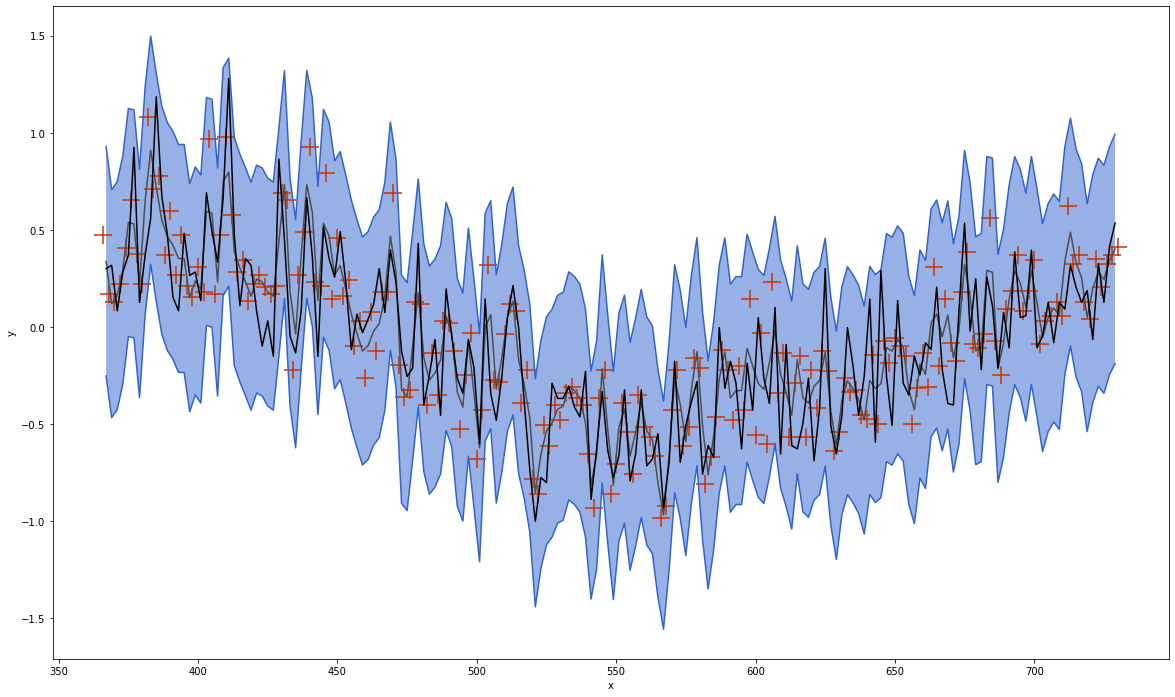

MSE GP:    0.04


In [31]:
plt.figure(figsize=(20,12))
pred_gp = gp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE GP: {0:7.2f}".format((np.square(yt - pred_gp[:,1])).mean()))

#### Part 2

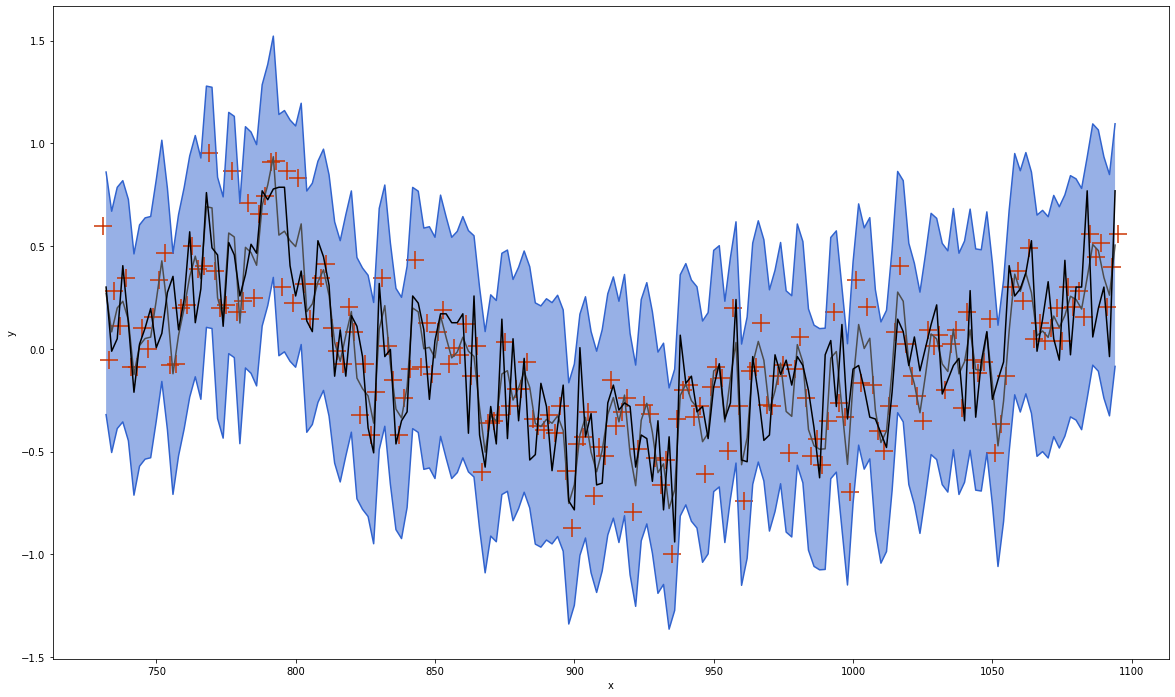

MSE GP:    0.03


In [32]:
plt.figure(figsize=(20,12))
pred_gp_2 = gp_predict(xc_2, yc_2, xt_2, np.transpose([xt_2, yt_2]))
print("MSE GP: {0:7.2f}".format((np.square(yt_2 - pred_gp_2[:,1])).mean()))

#### Part 3

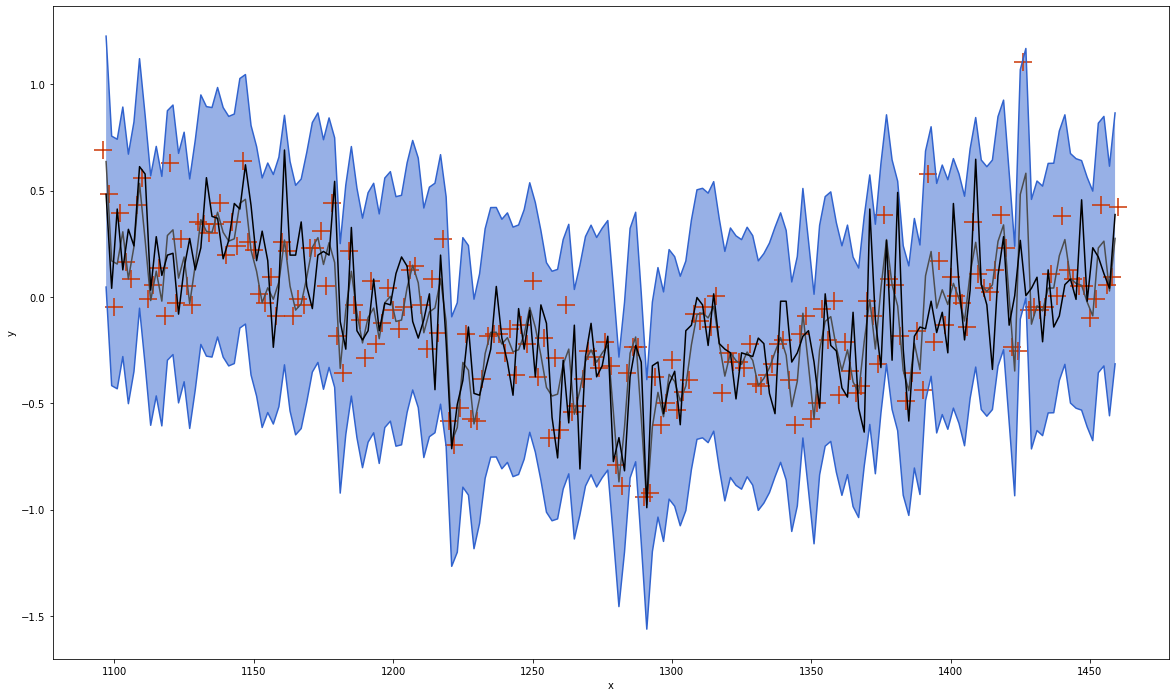

MSE GP:    0.04


In [33]:
plt.figure(figsize=(20,12))
pred_gp_3 = gp_predict(xc_3, yc_3, xt_3, np.transpose([xt_3, yt_3]))
print("MSE GP: {0:7.2f}".format((np.square(yt_3 - pred_gp_3[:,1])).mean()))

#### Part 4

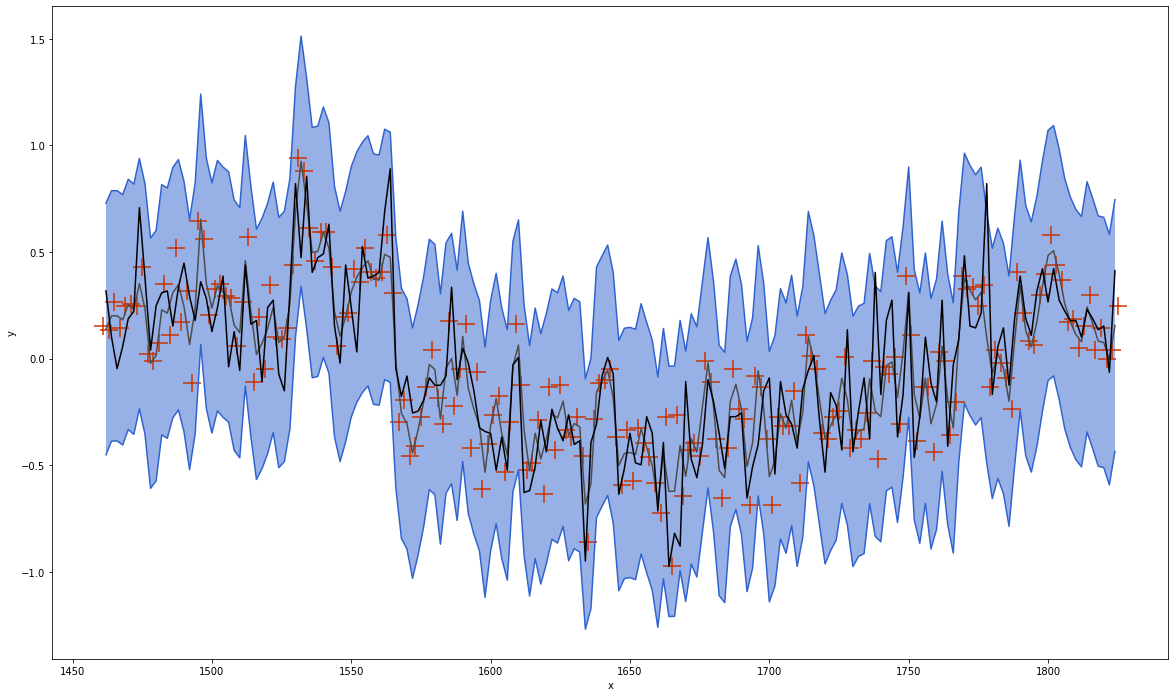

MSE GP:    0.03


In [34]:
plt.figure(figsize=(20,12))
pred_gp_4 = gp_predict(xc_4, yc_4, xt_4, np.transpose([xt_4, yt_4]))
print("MSE GP: {0:7.2f}".format((np.square(yt_4 - pred_gp_4[:,1])).mean()))

#### Part 5

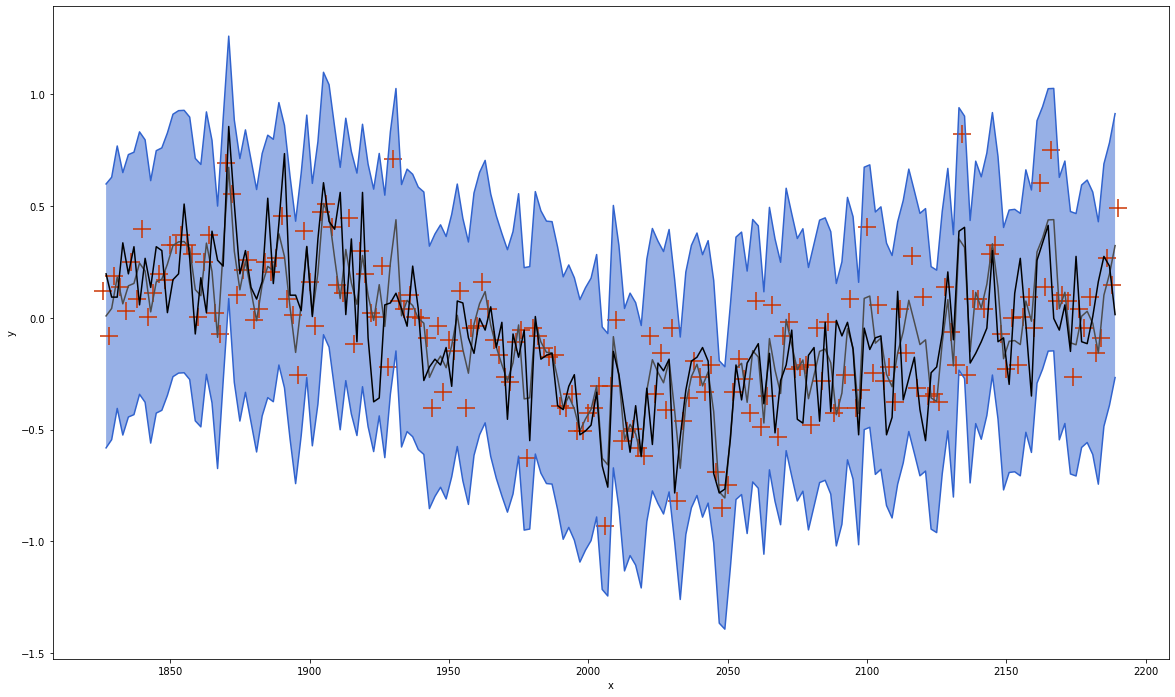

MSE GP:    0.03


In [35]:
plt.figure(figsize=(20,12))
pred_gp_5 = gp_predict(xc_5, yc_5, xt_5, np.transpose([xt_5, yt_5]))
print("MSE GP: {0:7.2f}".format((np.square(yt_5 - pred_gp_5[:,1])).mean()))

#### Part 6

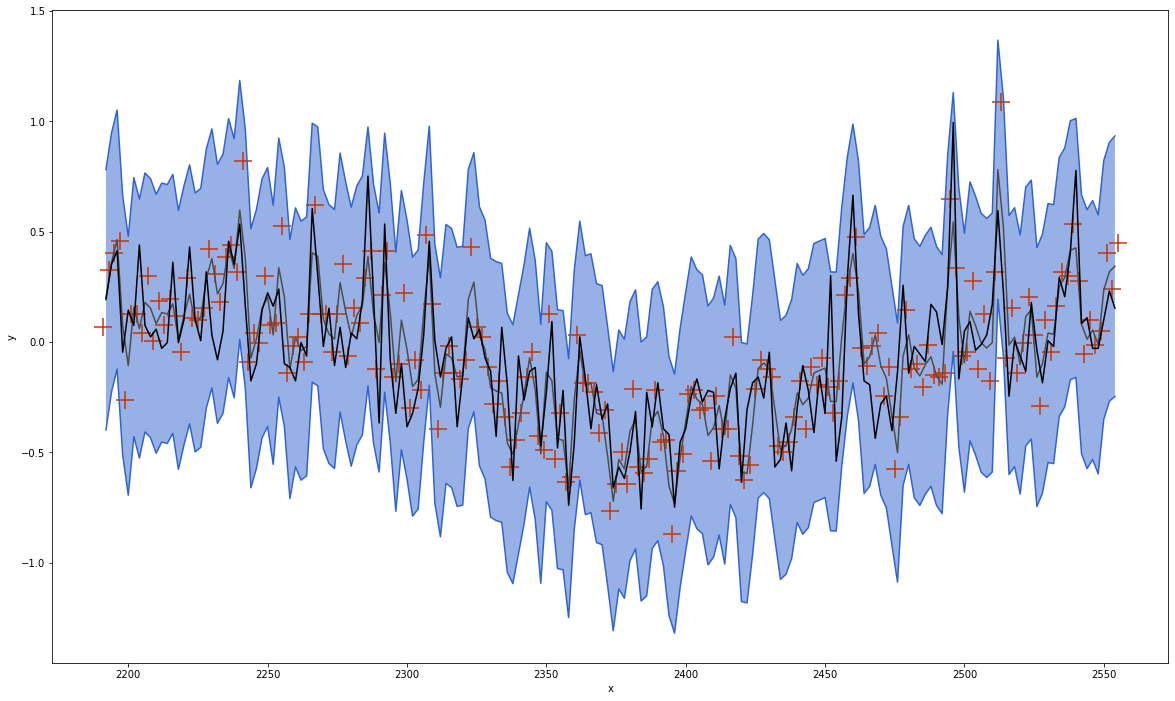

MSE GP:    0.03


In [36]:
plt.figure(figsize=(20,12))
pred_gp_6 = gp_predict(xc_6, yc_6, xt_6, np.transpose([xt_6, yt_6]))
print("MSE GP: {0:7.2f}".format((np.square(yt_6 - pred_gp_6[:,1])).mean()))

#### Part 7

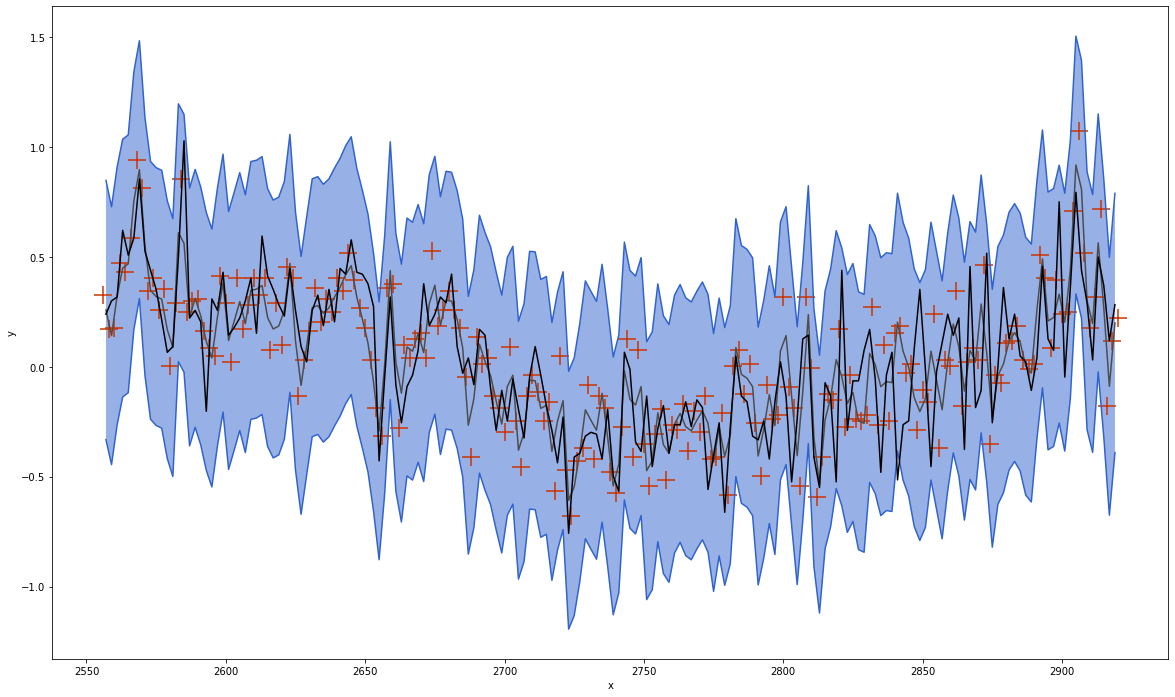

MSE GP:    0.04


In [37]:
plt.figure(figsize=(20,12))
pred_gp_7 = gp_predict(xc_7, yc_7, xt_7, np.transpose([xt_7, yt_7]))
print("MSE GP: {0:7.2f}".format((np.square(yt_7 - pred_gp_7[:,1])).mean()))

#### Part 8

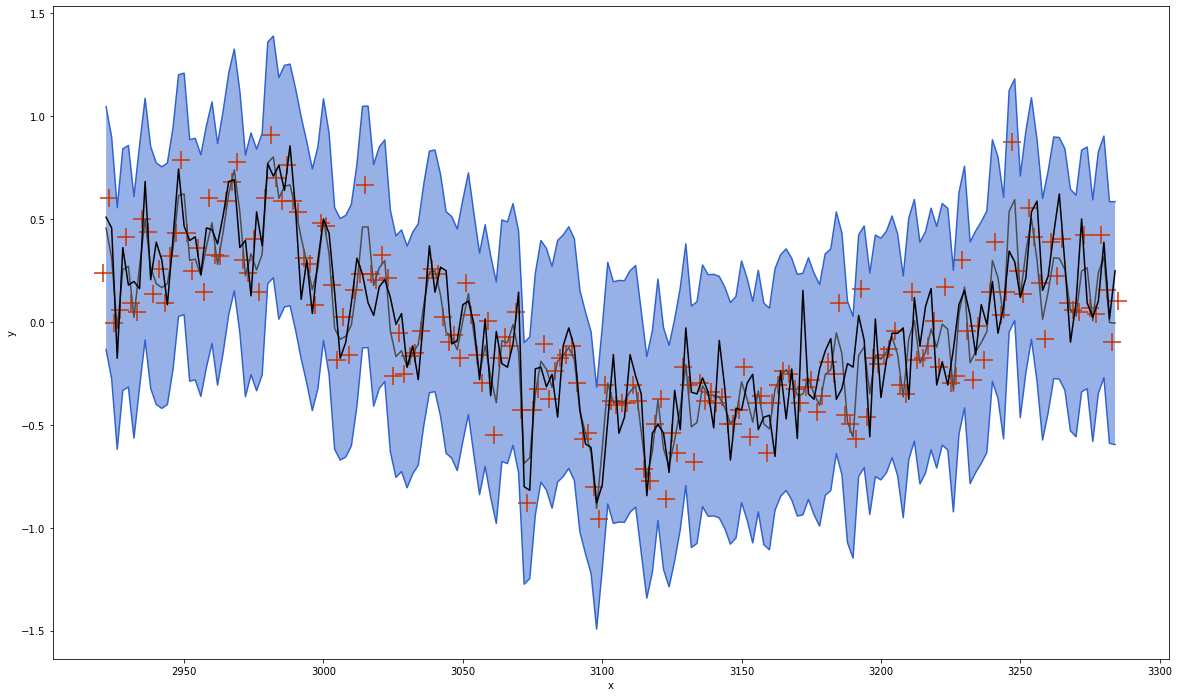

MSE GP:    0.03


In [38]:
plt.figure(figsize=(20,12))
pred_gp_8 = gp_predict(xc_8, yc_8, xt_8, np.transpose([xt_8, yt_8]))
print("MSE GP: {0:7.2f}".format((np.square(yt_8 - pred_gp_8[:,1])).mean()))

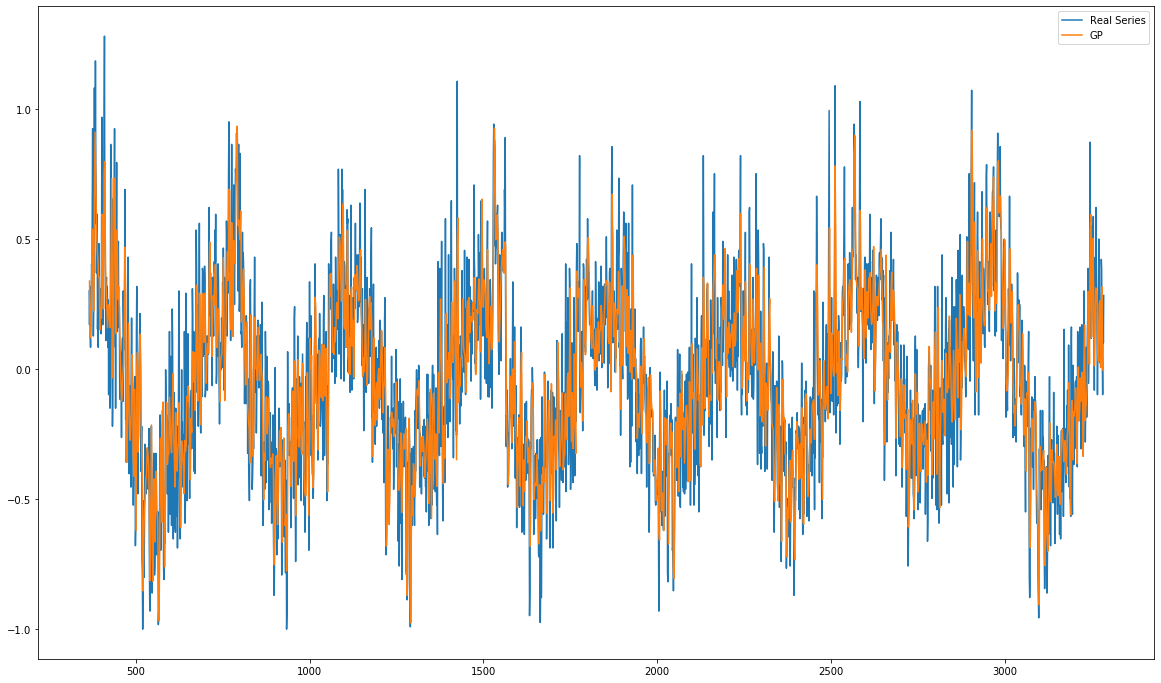

In [39]:
y_pred_gp_1=pd.DataFrame(pred_gp, index=xt.astype(int))[1]
y_pred_gp_2=pd.DataFrame(pred_gp_2, index=xt_2.astype(int))[1]
y_pred_gp_3=pd.DataFrame(pred_gp_3, index=xt_3.astype(int))[1]
y_pred_gp_4=pd.DataFrame(pred_gp_4, index=xt_4.astype(int))[1]
y_pred_gp_5=pd.DataFrame(pred_gp_5, index=xt_5.astype(int))[1]
y_pred_gp_6=pd.DataFrame(pred_gp_6, index=xt_6.astype(int))[1]
y_pred_gp_7=pd.DataFrame(pred_gp_7, index=xt_7.astype(int))[1]
y_pred_gp_8=pd.DataFrame(pred_gp_8, index=xt_8.astype(int))[1]

plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1,y_test_2,y_test_3,y_test_4,y_test_5,y_test_6,y_test_7,y_test_8]), label='Real Series')
plt.plot(pd.concat([y_pred_gp_1,y_pred_gp_2,y_pred_gp_3,y_pred_gp_4,y_pred_gp_5,y_pred_gp_6,y_pred_gp_7,y_pred_gp_8]), label='GP')
plt.legend()
plt.show()

### - CNP
#### Part 1

In [40]:
plt.figure(figsize=(20,12))
pred_cnp, max_pred_cnp, min_pred_cnp = cnp_predict(xc, yc, xt, np.transpose([xt, yt]))
print("MSE CNP: {0:7.2f}".format((np.square(yt - pred_cnp[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

In [41]:
pred_cnp

array([[367.,  nan],
       [369.,  nan],
       [371.,  nan],
       [373.,  nan],
       [375.,  nan],
       [377.,  nan],
       [379.,  nan],
       [381.,  nan],
       [383.,  nan],
       [385.,  nan],
       [387.,  nan],
       [389.,  nan],
       [391.,  nan],
       [393.,  nan],
       [395.,  nan],
       [397.,  nan],
       [399.,  nan],
       [401.,  nan],
       [403.,  nan],
       [405.,  nan],
       [407.,  nan],
       [409.,  nan],
       [411.,  nan],
       [413.,  nan],
       [415.,  nan],
       [417.,  nan],
       [419.,  nan],
       [421.,  nan],
       [423.,  nan],
       [425.,  nan],
       [427.,  nan],
       [429.,  nan],
       [431.,  nan],
       [433.,  nan],
       [435.,  nan],
       [437.,  nan],
       [439.,  nan],
       [441.,  nan],
       [443.,  nan],
       [445.,  nan],
       [447.,  nan],
       [449.,  nan],
       [451.,  nan],
       [453.,  nan],
       [455.,  nan],
       [457.,  nan],
       [459.,  nan],
       [461.,

#### Part 2

In [42]:
plt.figure(figsize=(20,12))
pred_cnp_2, max_pred_cnp_2, min_pred_cnp_2 = cnp_predict(xc_2, yc_2, xt_2, np.transpose([xt_2, yt_2]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_2 - pred_cnp_2[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 3

In [43]:
plt.figure(figsize=(20,12))
pred_cnp_3, max_pred_cnp_3, min_pred_cnp_3 = cnp_predict(xc_3, yc_3, xt_3, np.transpose([xt_3, yt_3]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_3 - pred_cnp_3[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 4

In [44]:
plt.figure(figsize=(20,12))
pred_cnp_4, max_pred_cnp_4, min_pred_cnp_4 = cnp_predict(xc_4, yc_4, xt_4, np.transpose([xt_4, yt_4]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_4 - pred_cnp_4[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 5

In [45]:
plt.figure(figsize=(20,12))
pred_cnp_5, max_pred_cnp_5, min_pred_cnp_5 = cnp_predict(xc_5, yc_5, xt_5, np.transpose([xt_5, yt_5]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_5 - pred_cnp_5[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 6

In [46]:
plt.figure(figsize=(20,12))
pred_cnp_6, max_pred_cnp_6, min_pred_cnp_6 = cnp_predict(xc_6, yc_6, xt_6, np.transpose([xt_6, yt_6]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_6 - pred_cnp_6[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 7

In [47]:
plt.figure(figsize=(20,12))
pred_cnp_7, max_pred_cnp_7, min_pred_cnp_7 = cnp_predict(xc_7, yc_7, xt_7, np.transpose([xt_7, yt_7]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_7 - pred_cnp_7[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

#### Part 8

In [48]:
plt.figure(figsize=(20,12))
pred_cnp_8, max_pred_cnp_8, min_pred_cnp_8 = cnp_predict(xc_8, yc_8, xt_8, np.transpose([xt_8, yt_8]))
print("MSE CNP: {0:7.2f}".format((np.square(yt_8 - pred_cnp_8[:,1])).mean()))

MSE CNP:     nan


<Figure size 1440x864 with 0 Axes>

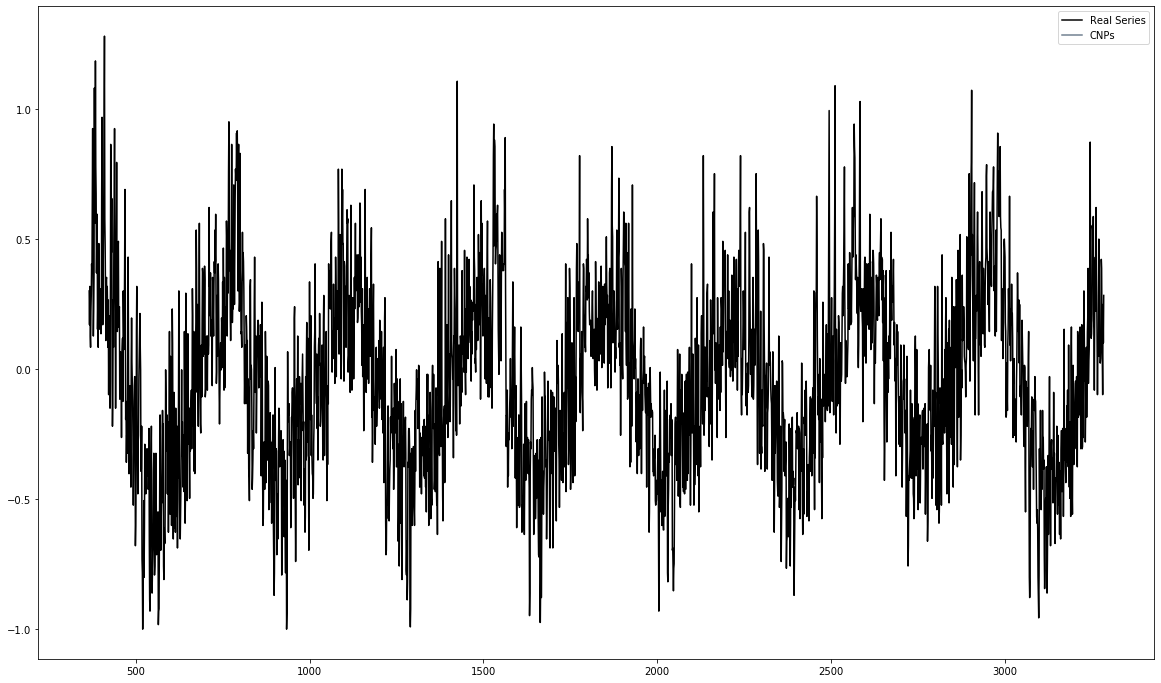

In [49]:
y_pred_cnp_1=pd.DataFrame(pred_cnp, index=xt.astype(int))[1]
y_pred_cnp_2=pd.DataFrame(pred_cnp_2, index=xt_2.astype(int))[1]
y_pred_cnp_3=pd.DataFrame(pred_cnp_3, index=xt_3.astype(int))[1]
y_pred_cnp_4=pd.DataFrame(pred_cnp_4, index=xt_4.astype(int))[1]
y_pred_cnp_5=pd.DataFrame(pred_cnp_5, index=xt_5.astype(int))[1]
y_pred_cnp_6=pd.DataFrame(pred_cnp_6, index=xt_6.astype(int))[1]
y_pred_cnp_7=pd.DataFrame(pred_cnp_7, index=xt_7.astype(int))[1]
y_pred_cnp_8=pd.DataFrame(pred_cnp_8, index=xt_8.astype(int))[1]

max_pred_cnp_1=pd.DataFrame(max_pred_cnp, index=xt.astype(int))[1]
max_pred_cnp_2=pd.DataFrame(max_pred_cnp_2, index=xt_2.astype(int))[1]
max_pred_cnp_3=pd.DataFrame(max_pred_cnp_3, index=xt_3.astype(int))[1]
max_pred_cnp_4=pd.DataFrame(max_pred_cnp_4, index=xt_4.astype(int))[1]
max_pred_cnp_5=pd.DataFrame(max_pred_cnp_5, index=xt_5.astype(int))[1]
max_pred_cnp_6=pd.DataFrame(max_pred_cnp_6, index=xt_6.astype(int))[1]
max_pred_cnp_7=pd.DataFrame(max_pred_cnp_7, index=xt_7.astype(int))[1]
max_pred_cnp_8=pd.DataFrame(max_pred_cnp_8, index=xt_8.astype(int))[1]

min_pred_cnp_1=pd.DataFrame(min_pred_cnp, index=xt.astype(int))[1]
min_pred_cnp_2=pd.DataFrame(min_pred_cnp_2, index=xt_2.astype(int))[1]
min_pred_cnp_3=pd.DataFrame(min_pred_cnp_3, index=xt_3.astype(int))[1]
min_pred_cnp_4=pd.DataFrame(min_pred_cnp_4, index=xt_4.astype(int))[1]
min_pred_cnp_5=pd.DataFrame(min_pred_cnp_5, index=xt_5.astype(int))[1]
min_pred_cnp_6=pd.DataFrame(min_pred_cnp_6, index=xt_6.astype(int))[1]
min_pred_cnp_7=pd.DataFrame(min_pred_cnp_7, index=xt_7.astype(int))[1]
min_pred_cnp_8=pd.DataFrame(min_pred_cnp_8, index=xt_8.astype(int))[1]

plt.figure(figsize=(20,12))
plt.plot(pd.concat([y_test_1,y_test_2,y_test_3,y_test_4,y_test_5,y_test_6,y_test_7,y_test_8]), label='Real Series', color='black')
plt.plot(pd.concat([y_pred_cnp_1,y_pred_cnp_2,y_pred_cnp_3,y_pred_cnp_4,y_pred_cnp_5,y_pred_cnp_6,y_pred_cnp_7,y_pred_cnp_8]), label='CNPs', color='slategrey')
plt.plot(pd.concat([max_pred_cnp_1,max_pred_cnp_2,max_pred_cnp_3,max_pred_cnp_4,max_pred_cnp_5,max_pred_cnp_6,max_pred_cnp_7,max_pred_cnp_8]), color='royalblue')
plt.plot(pd.concat([min_pred_cnp_1,min_pred_cnp_2,min_pred_cnp_3,min_pred_cnp_4,min_pred_cnp_5,min_pred_cnp_6,min_pred_cnp_7,min_pred_cnp_8]),color='royalblue')
plt.fill_between(np.concatenate((xt.astype(int),xt_2.astype(int),xt_3.astype(int),xt_4.astype(int),xt_5.astype(int),xt_6.astype(int),xt_7.astype(int),xt_8.astype(int)),
        axis=0),
                 pd.concat([max_pred_cnp_1,max_pred_cnp_2,max_pred_cnp_3,max_pred_cnp_4,max_pred_cnp_5,max_pred_cnp_6,max_pred_cnp_7,max_pred_cnp_8]),
                pd.concat([min_pred_cnp_1,min_pred_cnp_2,min_pred_cnp_3,min_pred_cnp_4,min_pred_cnp_5,min_pred_cnp_6,min_pred_cnp_7,min_pred_cnp_8]),
                color='lightsteelblue')
plt.legend()
plt.show()

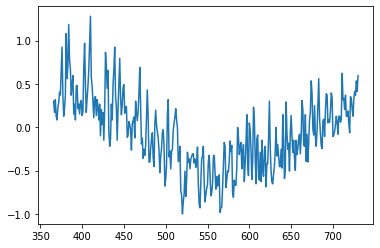

In [50]:
plt.plot(y_test_1)

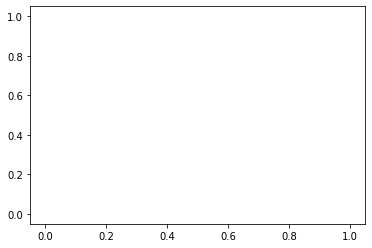

In [51]:
plt.plot(y_pred_cnp_1.pct_change())